#  Extract acoustic features for use in response time (RT) modeling

Step 1: Load packages

In [12]:
import parselmouth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import librosa
import pickle
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")

Step 2: Init paths

In [13]:
path_wav_files = './lisTest/tcdDecision/playback/STIMULI/'
wav_folder_types = ['chinese','english']
file_types = ['nspkrs_1','nspkrs_2']

path_store_feats = './dataAnalysis/data/feats/PRAAT/'
path_store_figure = './figures/'
# make direcs if absent
if not os.path.exists(path_store_feats):
    os.mkdir(path_store_feats)    

Step 3: Read listening test stimulus set filenames 

In [14]:
# read wav filenames with path
wav_files = []
for i in range(len(wav_folder_types)):
    wav_files.append([])
    for j in range(len(file_types)):
        wav_files[i].append([])
        for file in glob.glob(path_wav_files+wav_folder_types[i]+'/wavFilesTest/'+'*'+file_types[j]+'.wav'):
            wav_files[i][j].append(file)

Step 4: Extract acostic features using parselmouth (PRAAT) and Librosa packages. Extracted features are stored as a pickle file for each WAV file. 

In [16]:
# for PRAAT
sr = 16000
hop_dur = .01
num_form = 3
max_form_freq = 4500
win_dur = .040
# for LIBROSA

win_length = int(sr*win_dur)
hop_length = int(sr*hop_dur)
n_mfcc = 13
n_mels = 40
n_fft = 1024
window = 'hamming'
fmin = 75
fmax = 6500
                
for i in range(len(wav_files)):
    for j in range(len(wav_files[i])):
        for k in range(len(wav_files[i][j])):
            # read wav file
            x, sr = librosa.load(wav_files[i][j][k],sr=sr)
            x = x/np.max(abs(x))
            head, tail = os.path.split(wav_files[i][j][k])
            y = []
            # parse change instant and get two wav files
            changeIndex = int(float(tail.split('_nspkrs')[0].split('_')[-2]+\
            '.'+tail.split('_nspkrs')[0].split('_')[-1])*sr)
            y.append(x[:changeIndex])
            y.append(x[changeIndex:])
            # read and extract feats
            feats = {}
            for l in range(2):
                # save the segment files
                librosa.output.write_wav('./temp.wav', y[l], sr, norm=False)
                
                # extract librosa feats
                D = np.abs(librosa.stft(y[l], window=window, n_fft=n_fft, win_length=win_length, hop_length=hop_length,center=True))**2
                S = librosa.feature.melspectrogram(S=D, sr=sr, y=y[l], n_mels=n_mels, fmin=fmin, fmax=fmax)
                feats['mel_'+str(l+1)] = librosa.power_to_db(S).T
                feats['mfcc_'+str(l+1)] = librosa.feature.mfcc(S=librosa.power_to_db(S), sr=sr, n_mfcc=n_mfcc).T
                feats['scentroid_'+str(l+1)] = librosa.feature.spectral_centroid(S=D, sr=sr).T

                # use PRAAT to extract following
                snd = parselmouth.Sound('temp.wav')
                pitch = snd.to_pitch(time_step=hop_dur) # window is 40 msec
                harm = snd.to_harmonicity(time_step=hop_dur) # window is 40 msec
                form = snd.to_formant_burg(time_step=hop_dur,max_number_of_formants=num_form, maximum_formant = max_form_freq,
                                           window_length=win_dur, pre_emphasis_from=50.0)
                intensity = snd.to_intensity(minimum_pitch = 75.0, time_step=hop_dur,subtract_mean=False)
                frames = np.arange(0,feats['mel_'+str(l+1)].shape[0],1)
                times = librosa.core.frames_to_time(frames, sr=sr, hop_length=hop_length)
#                 times = pitch.xs()
                pitch_vals = []
                harm_vals = []
                form_1_vals = []
                form_2_vals = []
                form_3_vals = []
                inten_vals = []
                for dt in times:
                    pitch_vals.append(pitch.get_value_at_time(dt))
                    harm_vals.append(harm.get_value(dt))
                    form_1_vals.append(form.get_value_at_time(1,dt))
                    form_2_vals.append(form.get_value_at_time(2,dt))
                    form_3_vals.append(form.get_value_at_time(3,dt))
                    inten_vals.append(intensity.get_value(dt))
                feats['pitch_'+str(l+1)] = np.array(pitch_vals)[:,None]
                feats['harm_'+str(l+1)] = np.array(harm_vals)[:,None]
                feats['intensity_'+str(l+1)] = np.array(inten_vals)[:,None]
                feats['form_1_'+str(l+1)] = np.array(form_1_vals)[:,None]
                feats['form_2_'+str(l+1)] = np.array(form_2_vals)[:,None]
                feats['form_3_'+str(l+1)] = np.array(form_3_vals)[:,None]
                
                # voice/unvoiced
                where_are_NaNs = np.isnan(feats['pitch_'+str(l+1)])
                feats['pitch_'+str(l+1)][where_are_NaNs] = 0
                
                where_are_NaNs = np.isnan(feats['harm_'+str(l+1)])
                feats['harm_'+str(l+1)][where_are_NaNs] = 0
                
                where_are_NaNs = np.isnan(feats['intensity_'+str(l+1)])
                feats['intensity_'+str(l+1)][where_are_NaNs] = 0
                if np.isnan(np.sum(feats['pitch_'+str(l+1)])):
                    print(1/0)
                elif np.isinf(np.sum(feats['pitch_'+str(l+1)])):
                    print(1/0)
                else:
                    indx = np.where((feats['pitch_'+str(l+1)]>80)&(feats['pitch_'+str(l+1)]<350)&\
                                   (feats['harm_'+str(l+1)]>0))[0]
                    feats['voiced_'+str(l+1)] = indx
            # xvec   
            if i == 0:
                with open('./dataAnalysis/data/feats/xvec'+'/'+'xvectors_chinese.pkl', 'rb') as f:
                    x = pickle.load(f)  
            else:
                with open('./dataAnalysis/data/feats/xvec'+'/'+'xvectors_english.pkl', 'rb') as f:
                    x = pickle.load(f)
            if tail[:-4] not in x:
                print('file absent')
                feats['xvec_1'] = np.ones((512,1))
                feats['xvec_2'] = np.ones((512,1))
            else:
                x = x[tail[:-4]]
                feats['xvec_1'] = x[0][:,None]
                feats['xvec_2'] = x[1][:,None]
            # change ins
            feats['tc'] = np.array([changeIndex/sr])
            # dur
            feats['dur'] = np.array([len(x)/sr])
            # save feats
            with open(path_store_feats+tail[:-4]+'.pickle', 'wb') as f:
                pickle.dump(feats, f)
print('The absent files are TRAIN files. No worries as we analyze only TEST files')

file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent
file absent


In [17]:
# view the keys of the dictionary
for key in feats.keys():
    print(key)
    print(feats[key].shape)

mel_1
(487, 40)
mfcc_1
(487, 13)
scentroid_1
(487, 1)
pitch_1
(487, 1)
harm_1
(487, 1)
intensity_1
(487, 1)
form_1_1
(487, 1)
form_2_1
(487, 1)
form_3_1
(487, 1)
voiced_1
(245,)
mel_2
(289, 40)
mfcc_2
(289, 13)
scentroid_2
(289, 1)
pitch_2
(289, 1)
harm_2
(289, 1)
intensity_2
(289, 1)
form_1_2
(289, 1)
form_2_2
(289, 1)
form_3_2
(289, 1)
voiced_2
(172,)
xvec_1
(512, 1)
xvec_2
(512, 1)
tc
(1,)
dur
(1,)


Step 5: Pool few features from chinese and english to visualize 

In [22]:
# pool features of CHIN and ENG
feat_type = ['pitch','hns','inten']
feats_stack = np.ones((44,1),dtype=float)
labels_stack = np.ones((1,1),dtype=float)
for i in range(len(wav_files)):
    for j in range(len(wav_files[i])):
        for k in range(len(wav_files[i][j])):
            head, tail = os.path.split(wav_files[i][j][k])
            with open(path_store_feats+tail[:-4]+'.pickle', 'rb') as f:
                feats = pickle.load(f)
            temp_1 = np.vstack((feats['pitch_1'].T,feats['harm_1'].T,\
                                feats['intensity_1'].T,feats['scentroid_1'].T,\
                                feats['mel_1'].T))
            temp_1 = temp_1[:,feats['voiced_1']]
            temp_2 = np.vstack((feats['pitch_2'].T,feats['harm_2'].T,\
                                feats['intensity_2'].T,feats['scentroid_2'].T,\
                                feats['mel_2'].T))
            temp_2 = temp_2[:,feats['voiced_2']]
            temp = np.hstack((temp_1,temp_2))
            feats_stack = np.hstack((feats_stack,temp))
            labels_stack = np.hstack((labels_stack,i*np.ones((1,temp.shape[1]))))
feats_stack = np.delete(feats_stack, [0], axis=1)
labels_stack = np.delete(labels_stack, [0], axis=1)


Step 6: Plot the density plots for the features

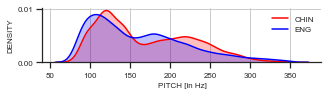

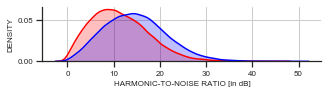

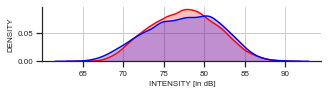

In [24]:
fig = plt.subplots(figsize=(5,1))
ax = plt.subplot(1,1,1)
sns.kdeplot(feats_stack[0,(labels_stack==0)[0,:]],shade=True,color='red',label='CHIN')
sns.kdeplot(feats_stack[0,(labels_stack==1)[0,:]],shade=True,color='blue',label='ENG')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_xlabel('PITCH [in Hz]',fontsize=8)
ax.set_ylabel('DENSITY',fontsize=8)
ax.legend(loc='upper right',frameon=False,fontsize=8)
ax.figure.savefig(path_store_figure+"audiodata_pitch.pdf", bbox_inches='tight')
plt.show()

fig = plt.subplots(figsize=(5,1))
ax = plt.subplot(1,1,1)
sns.kdeplot(feats_stack[1,(labels_stack==0)[0,:]],shade=True,color='red')
sns.kdeplot(feats_stack[1,(labels_stack==1)[0,:]],shade=True,color='blue')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('DENSITY',fontsize=8)
ax.set_xlabel('HARMONIC-TO-NOISE RATIO [in dB]',fontsize=8)
ax.figure.savefig(path_store_figure+"audiodata_hnr.pdf", bbox_inches='tight')
plt.show()

fig = plt.subplots(figsize=(5,1))
ax = plt.subplot(1,1,1)
sns.kdeplot(feats_stack[2,(labels_stack==0)[0,:]],shade=True,color='red')
sns.kdeplot(feats_stack[2,(labels_stack==1)[0,:]],shade=True,color='blue')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_xlabel('INTENSITY [in dB]',fontsize=8)
ax.set_ylabel('DENSITY',fontsize=8)
ax.figure.savefig(path_store_figure+"audiodata_intensity.pdf", bbox_inches='tight')
plt.show()


Step 7: Do an LDA of the features to see an separation between acoustic features of chinese and english

explained variance ratio (first two components): [0.94472903 0.02516815]


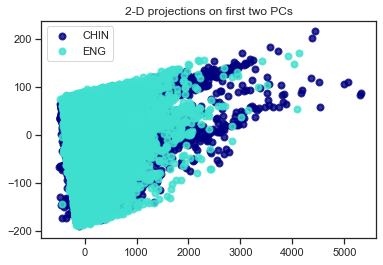

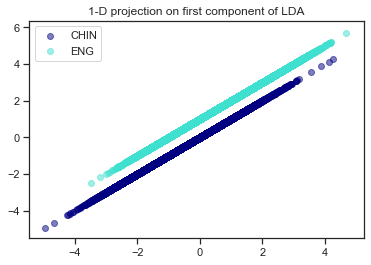

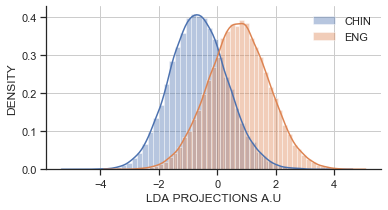

In [26]:
X = feats_stack.T
y = labels_stack.T[:,0]

target_names = ['CHIN','ENG']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('2-D projections on first two PCs')

plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 0]+i, alpha=.5, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('1-D projection on first component of LDA')
plt.show()


fig = plt.subplots(figsize=(6,3))
ax = plt.subplot(1,1,1)
sns.distplot(X_r2[y == 0, 0],label='CHIN')
sns.distplot(X_r2[y == 1, 0],label='ENG')
# sns.kdeplot(np.reciprocal(rt_spkr_2[0]), shade=True,color='red',label='eng')
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('LDA PROJECTIONS A.U')
ax.set_ylabel('DENSITY')
ax.legend(loc='upper right',frameon=False)
plt.show()



In [5]:
# euclidean distance
feats_column_name = ['pitch','mfcc', 'mel','scentroid','harm','intensity','xvec']


feats_distance = []
feats_distance.append([])
feats_distance[0].append('fname')
feats_distance[0].append('lang')
feats_distance[0].append('changeIns')
for i in range(len(feats_column_name)):
    feats_distance[0].append(feats_column_name[i])
cnt = 1
for i in range(len(wav_files)):
    for j in range(len(wav_files[i])):
        for k in range(len(wav_files[i][j])):
            feats_distance.append([])
            head, tail = os.path.split(wav_files[i][j][k])

            # load pickle file
            with open(path_store_feats+tail[:-4]+'.pickle', 'rb') as f:
                feats = pickle.load(f) 
            
            feats_distance[cnt].append(tail[:-4])
            feats_distance[cnt].append(i)
            changeIns = float(tail.split('_nspkrs')[0].split('_')[-2]+\
                                    '.'+tail.split('_nspkrs')[0].split('_')[-1])
            feats_distance[cnt].append(changeIns)
            
            # find euclidean distance
            for feats_name in feats_column_name:
                if feats_name!='xvec':
                    temp_1 = feats[feats_name+'_1'][feats['voiced_1']]
                    temp_2 = feats[feats_name+'_2'][feats['voiced_2']]
#                     X = np.vstack((temp_1,temp_2))
#                     y = np.vstack((0*np.ones((temp_1.shape[0],1)),np.ones((temp_2.shape[0],1))))[:,0]
#                     lda = LinearDiscriminantAnalysis(n_components=2)
#                     X_p = lda.fit(X, y).transform(X)
#                     inter_class_scatter = np.linalg.norm(np.mean(X_p[y == 0, 0]) - np.mean(X_p[y == 1, 0]))**2 
#                     intra_class_scatter = np.sum(np.var(X_p[y == 0, 0])+ np.var(X_p[y == 1, 0]))
#                     dist = inter_class_scatter/intra_class_scatter
                    temp_1 = np.mean(temp_1,axis=0)
                    temp_2 = np.mean(temp_2,axis=0)
                    dist = np.linalg.norm(temp_1-temp_2)
                if feats_name == 'xvec':
                    dist = np.linalg.norm(feats[feats_name+'_1']-feats[feats_name+'_2'])
                feats_distance[cnt].append(dist)
            cnt = cnt+1
df = pd.DataFrame(feats_distance)
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

In [6]:
df

,fname,lang,changeIns,pitch,mfcc,mel,scentroid,harm,intensity,xvec
1,BAC009S0661W0448_BAC009S0661W0338_03_86_nspkrs_1,0,3.86,10.2772,39.9285,40.4607,90.7651,3.8762,2.38415,36.7997
2,BAC009S0091W0409_BAC009S0091W0381_04_56_nspkrs_1,0,4.56,13.1086,25.0946,26.6424,94.1887,5.56914,2.91429,24.769
3,BAC009S0249W0357_BAC009S0249W0241_03_63_nspkrs_1,0,3.63,9.67927,21.1335,22.0274,116.81,1.33879,3.292,34.5808
4,BAC009S0064W0353_BAC009S0064W0267_03_02_nspkrs_1,0,3.02,1.52673,21.6705,22.0982,213.698,0.341891,0.392727,31.2156
5,BAC009S0195W0418_BAC009S0195W0360_03_84_nspkrs_1,0,3.84,6.69881,25.5336,30.5099,180.282,0.840069,1.17161,32.2397
...,...,...,...,...,...,...,...,...,...,...
212,1246-135815-0016_2582-155972-0027_03_60_nspkrs_2,1,3.6,7.74052,46.6295,51.0181,456.791,4.249,2.71018,47.5113
213,2764-36619-0018_6233-36633-0005_03_83_nspkrs_2,1,3.83,7.99014,33.7547,36.2952,495.197,1.08948,8.98988,39.5384
214,3307-145138-0027_7258-91902-0031_04_20_nspkrs_2,1,4.2,0.769653,47.3439,48.4925,165.859,2.38756,0.314683,53.0054
215,1903-132499-0080_6701-71402-0007_02_75_nspkrs_2,1,2.75,1.76438,36.7396,37.3689,644.248,4.26183,1.439,46.9732


In [8]:
# read data
audio_type = ['chin','eng']
sub_IDs = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15',
          'S16','S17','S18','S19','S20','S21','S22','S23','S24','S25','S26','S27','S28','S29']

miss = []
fa = []
hit = []
rt_miss = []
rt_fa = []
rt_hit = []

fa_names = []
miss_names = []
hit_names = []
rt_correct = []
rt_incorrect = []

df = pd.DataFrame() 

for i in range(len(sub_IDs)):
    for j in range(len(audio_type)):
        if 1: # read from local repo
            url = './lisTest/tcdDecision/recordings/New_recordings/'+audio_type[j]+'_'+sub_IDs[i]+'/keys.csv'
        else: # read from online repo
            url = 'https://raw.githubusercontent.com/neerajww/lang_tcd/venkat201097-test1/code/lisTest/tcdDecision/recordings/New_recordings/'+audio_type[j]+'_'+sub_IDs[i]+'/keys.csv'
        # load csv into a dataframe
        temp = pd.read_csv(url,header=None)
        temp['subID'] = i+1
        df = df.append(temp, ignore_index = True)

In [9]:
DF = df.copy()
for i in range(len(feats_column_name)):
    DF[feats_column_name[i]] = 0
DF['lang'] = 0
DF['changeIns'] = 0

for i in range(len(DF)):
    for j in range(len(feats_distance)):
        fname = DF[1].values[i]
        head, tail = os.path.split(fname)
        if feats_distance[j][0] == tail[:-4]:
            for k in range(len(feats_column_name)):
                DF.loc[i,feats_column_name[k]] = feats_distance[j][3+k] 
            DF.loc[i,'lang'] = feats_distance[j][1] 
            DF.loc[i,'changeIns'] = feats_distance[j][2]
DF.rename(columns={0: "fIndex", 1: "fname",2:'label',3:'response',4:'session',5:'t_start',6:"t_end",7:"t_resp"},
          inplace = True)
# save csv
DF.to_csv('./dataAnalysis/data/csvs/praat_pooled_subject_response_acoustic_feats_data_euc.csv',index=False) 

In [ ]:
DF